In [16]:

from bounding_box_utils.bounding_box_utils import iou
import numpy as np
import json
import math
import scipy.interpolate as interp
from scipy.spatial import distance
def bounding_box_naive(points):
    """returns a list containing the bottom left and the top right 
    points in the sequence
    Here, we use min and max four times over the collection of points
    """
    

    top_left_x = min(point[0][0] for point in points)
    top_left_y = min(point[0][1] for point in points)
    bot_right_x = max(point[0][0] for point in points)
    bot_right_y = max(point[0][1] for point in points)

    center_x = (top_left_x+bot_right_x)/2
    center_y = (top_left_y+bot_right_y)/2
    

    
    return [center_x,center_y,bot_right_x-top_left_x,bot_right_y-top_left_y]
def histogram_intersection(h1, h2):
    sm = 0
    for i in range(h1.shape[0]):
        sm += min(h1[i], h2[i])
    return sm
def shiftKeypointsFlow(frame,prev_frame,track):
    frame_grey = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
    prev_frame_grey = cv.cvtColor(prev_frame,cv.COLOR_BGR2GRAY)
    mask = np.zeros(frame_grey.shape, dtype = "uint8")


    cv.rectangle(mask, (int(track[3]), int(track[4])), (int(track[5]), int(track[6])), (255, 255, 255), -1)
    p0 = cv.goodFeaturesToTrack(prev_frame_grey, mask = mask, **feature_params)
    
    if(not p0 is None ):
        p1, st, err = cv.calcOpticalFlowPyrLK(prev_frame_grey, frame_grey,p0, None, **lk_params)
       
        
        old_box = bounding_box_naive(p0)
        new_box = bounding_box_naive(p1)
       
        offset = [new_box[0]-old_box[0],new_box[1]-old_box[1]]
        
        new_center = center(track)+offset
        
        old_width = track[5] - track[3]
        old_height = track[6]-track[4]
        
        new_width = old_width * (new_box[2]/old_box[2])
        
        new_height = old_height * (new_box[3]/old_box[3])
        
        if(new_width==0 or new_width>frame_width or math.isnan(new_width)):
            new_width=0
        if(new_height==0 or new_height>frame_height or math.isnan(new_height)):
            new_height=0
        
        track[3] = new_center[0] - (new_width/2)
        track[4]=new_center[1] - (new_height/2)
        track[5]=new_center[0] + (new_width/2)
        track[6]=new_center[1]+ (new_height/2)
    else:
        track[2] = 0
def shiftKeypointsFlow_old(frame,prev_frame,track):
    frame_grey = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
    prev_frame_grey = cv.cvtColor(prev_frame,cv.COLOR_BGR2GRAY)
    mask = np.zeros(frame_grey.shape, dtype = "uint8")


    cv.rectangle(mask, (int(track[3]), int(track[4])), (int(track[5]), int(track[6])), (255, 255, 255), -1)
    p0 = cv.goodFeaturesToTrack(prev_frame_grey, mask = mask, **feature_params)
    
    if(not p0 is None ):
        p1, st, err = cv.calcOpticalFlowPyrLK(prev_frame_grey, frame_grey,p0, None, **lk_params)
        average_flow = np.median(p1-p0,0)[0]
        track[3] += average_flow[0]
        
        track[4]+=average_flow[1]
        track[5]+=average_flow[0]
        track[6]+=average_flow[1]
    else:
        track[2] =0
        
    
    
    
def corners_to_width_height(box):
    box2 = np.zeros((4),np.float32)
    box2[0] = box[0]
    box2[1] = box[1]
    box2[2] = box[2]-box[0]
    box2[3] = box[3]-box[1]
    return box2
def get_iou(a, b, epsilon=1e-5):
    
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou
def boxes_match(box1,box2,iou_threshold=0.4):
    
    if(box1[1]!=box2[1] or box1[7]==1 or box2[7]==1):
        return False
    
    return iou(box1[3:7],box2[3:7],coords='corners')>0

def get_nextGlob_Id(Cur_ID):
    Cur_ID+=1
    return Cur_ID
def get_next_id(tracks):
    ids = [t[0] for t in tracks]
    if(len(ids)>0):
        return (np.max(ids)+1)
    else:
        return 0
def box_matches_list(box1,list_boxes):
    index =-1
    if(len(list_boxes)==0):
        return index
    match_list = []
    box_index =0
    
    for box in list_boxes:
       
        if(box.shape[0]>0):
            
            if(box.shape[0]==1):
                
                if(boxes_match(box[0],box1)):
                    match_list.append(box_index)
                    
            elif(box.shape[0]==8):
                
                if(boxes_match(box,box1)):
                    
                    match_list.append(box_index)
        box_index+=1
    
    if(len(match_list)== 0):
        return index
    max_match_index = 0
    max_match_iou = 0
    for i in match_list:
        cur_iou = iou(box1[3:7],list_boxes[i][3:7],coords='corners')
        
        if(cur_iou>max_match_iou):
            max_match_iou=cur_iou
            max_match_index =i
    list_boxes[max_match_index][7] = 1
    box1[7] = 1
    
    return max_match_index


def center(box):
    
    return np.array([(box[3]+box[5])/2,(box[4]+box[6])/2],np.float32)
  
def topleft(box):
    return np.array([box[3],box[4]],np.float32)
def botright(box):
    return np.array([box[5],box[6]],np.float32)
def corners(box):
    z = np.zeros(4,np.float32)
    z[:2] = topleft(box)
    z[2:4] = botright(box)
    return z
def shiftCenterFlow(frame,prev_frame,track,flow):
    
    xmin = int(track[3])
    ymin = int(track[4] )
    xmax =int(track[5] )
    ymax =int(track[6])
    frame_grey = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
    prev_frame_grey = cv.cvtColor(prev_frame,cv.COLOR_BGR2GRAY)
    center_flow = flow[np.minimum(int((xmin+xmax)/2),flow.shape[0]-1),np.minimum(int((ymin+ymax)/2),flow.shape[1]-1)]
    track[3] += center_flow[0]
    track[5]+=center_flow[1]
    track[4]+=center_flow[0]
    track[6]+=center_flow[1]

def add_kalman_corners(initial):
    
    kalman = cv.KalmanFilter(8,4)
    kalman.measurementMatrix = np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0]],np.float32)

    kalman.transitionMatrix = np.array([[1,0,0,0,1,0,0,0],[0,1,0,0,0,1,0,0],[0,0,1,0,0,0,1,0],[0,0,0,1,0,0,0,1]
                                       ,[0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]],np.float32)

    kalman.processNoiseCov = np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0]
                                      ,[0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]],np.float32)*0.001
    
    kalman.predict();
    
    kalman.correct(initial)
    kalman.predict();
    kalman.correct(initial)
    kalman.predict();
    kalman.correct(initial)
    kalman.predict();
    kalman.correct(initial)
    kalman_trackers.append(kalman)
def add_kalman_center(initial):
    
    kalman = cv.KalmanFilter(4,2)
    kalman.measurementMatrix = np.array([[1,0,0,0],
                                     [0,1,0,0]],np.float32)

    kalman.transitionMatrix = np.array([[1,0,1,0],
                                    [0,1,0,1],
                                    [0,0,1,0],
                                    [0,0,0,1]],np.float32)

    kalman.processNoiseCov = np.array([[1,0,0,0],
                                   [0,1,0,0],
                                   [0,0,1,0],
                                   [0,0,0,1]],np.float32) * 0.03
    
    kalman.predict();
    
    kalman.correct(initial)
    kalman.predict();
    kalman.correct(initial)
    kalman.predict();
    kalman.correct(initial)
    kalman.predict();
    kalman.correct(initial)
    kalman_trackers.append(kalman)
def get_distance(v1,v2):
    
    if(len(v1)==len(v2)):
        dist = distance.euclidean(np.array(v1),np.array(v2))
    elif(len(v1)>len(v2)):
        print('interplation')
        v2_func = interp.interp1d(np.arange(len(v2)),v2)
        v2_mod = v2_func(np.linspace(0,len(v2)-1,len(v1)))
        dist = np.linalg.norm(np.array(v1)-np.array(v2_mod))
    else:
        print('interplation')
        v1_func = interp.interp1d(np.arange(len(v1)),v1)
        v1_mod = v1_func(np.linspace(0,len(v1)-1,len(v2)))
        dist = np.linalg.norm(np.array(v1_mod)-np.array(v2))
    if(dist>1000):
        dist=30
    return dist
    
    
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

In [17]:
def load_detections(dataset,detector):
    text_file_path = "detections/%s/%s.txt"%(dataset,detector)
    f = open(text_file_path,"r")
    line = f.readline()
    detections={}
    comps = []
    while(line):

        line = line.replace("\n", "")
        comps = line.split(",")
        
        if(comps[0] in detections):
            detections[comps[0]].append(list(map(float, comps[2:])))
        else:
            detections[comps[0]]=[]
            detections[comps[0]].append(list(map(float, comps[2:])))
        line=f.readline()
    f.close()
    return detections


In [18]:

from imutils.video import VideoStream
import argparse
import datetime
import motmetrics as mm
import imutils
import time
from sklearn import preprocessing
import cv2 as cv
import time
from sort import *
from sklearn.utils.linear_assignment_ import linear_assignment
import json
from bounding_box_utils.bounding_box_utils import iou

acc = mm.MOTAccumulator(auto_id=True)
feature_params = dict( maxCorners = 30,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
iou_overlaps = []
desc_dists = []
confusion_frames = []
confusion_tracks = []
confusion_distances =[]
colors = [[255,0,0],[0,255,0],[0,0,255],[0,128,128],[128,0,128],[128,128,0],[255,0,0],[0,255,0],[0,0,255],[0,128,128],[128,0,128],[128,128,0],
         [255,0,0],[0,255,0],[0,0,255],[0,128,128],[128,0,128],[128,128,0],[255,0,0],[0,255,0],[0,0,255],[0,128,128],[128,0,128],[128,128,0],[255,0,0],[0,255,0],[0,0,255],[0,128,128],[128,0,128],[128,128,0]]
tracking_methods=['keypoint_flow']
#tracking_methods=['center_flow','keypoint_flow','kalman_center','kalman_corners','SORT']
detectors = ['yolo']
#detectors = ['ssd300','retinanet','yolo']
#'center_flow','keypoint_flow','kalman_center','kalman_corners',
datasets=['modd']
times = {}
for dataset in datasets:
    times[dataset]={}
    images_input_path='../%s/'%dataset
    image_id_prefix= dataset
    frame_width=1032
    frame_height=778
    if(dataset=='venc'):
        frame_width = 1280
        frame_height = 960
    if(dataset=='modd'):
        frame_width=640
        frame_height=464
    if(dataset=='mot_1'):
        frame_width=768
        frame_height=576
    iou_threshold = 0.1
    for detector in detectors:
        times[dataset][detector] = {}
        boat_class=8
        min_conf=0.6
        if(detector=='ssd300'):
            boat_class=4
            min_conf=0.5
        if(detector=='def'):
            boat_class=1
        

        path = '%s/%s_videos'%(detector,image_id_prefix)
        detections = load_detections(image_id_prefix,detector)
        for tracking_method in tracking_methods:
            times[dataset][detector][tracking_method] = []
            video_output_path='%s/%s.avi'%(path,tracking_method)
            json_output_path='%s/%s.json'%(path,tracking_method)
            out_tracking = cv.VideoWriter(video_output_path,cv.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))
            frameCount =0
            no_tracking_res = [] 
            tracking_res = []
            kalman_trackers=[]
            # initialize the first frame in the video stream
            frameCount =0
            step_up = 0.1
            step_down = 0.2
            print('Running: Dataset:%s, Detector:%s, Tracker:%s, @%dx%d'%(dataset,detector,tracking_method,frame_width,frame_height))
            preds = []
            tracks=[]
            started = False
            multiplier=0
            cc=0
            prev_frame=None

            total_frames=641
            if(tracking_method=='SORT'):
                mot_tracker = Sort()
            Cur_ID=0
            while frameCount<total_frames:
                
                # grab the current frame and initialize the occupied/unoccupied
                # text
                frame = cv.imread('%s%s.jpg'%(images_input_path,str(frameCount+1).zfill(5)))
                
                
                # if the frame could not be grabbed, then we have reached the end
                # of the video
                if frame is None:
                    break

                if(frameCount<0):
                    continue

                preds = []
                if '%s/%s.jpg'%(image_id_prefix,str(frameCount+1).zfill(5)) in detections:

                    for box in detections['%s/%s.jpg'%(image_id_prefix,str(frameCount+1).zfill(5))]:

                        if(box[0]!=boat_class or box[1]<min_conf):

                            continue
                        if(tracking_method=='SORT'):
                            temp_pred = box[2:]

                            temp_pred = np.insert(temp_pred,4,box[1])

                            preds.append(temp_pred)
                        else :
                            temp_pred = np.insert(box,0,0)
                            temp_pred = np.insert(temp_pred,7,0)
                            temp_pred = np.insert(temp_pred,8,1)
                            temp_pred = np.insert(temp_pred,9,0)
                            preds.append(temp_pred)
                start= time.time()
                if(tracking_method=='SORT'):

                    preds = np.asarray(preds)
                    trackers = mot_tracker.update(preds)
                    to_display = []
                    for itrk,tracker in enumerate(trackers):
                        to_display.append([tracker[4],boat_class,preds[itrk][4],tracker[0],tracker[1],tracker[2],tracker[3]])
                else:   
                    
                    #print(len(prev_pred),len(temp),len(entered_pred),len(exited_pred))

                    #print("Before matching---------:")
                    #if(frameCount>480):
                        #print([t[0:10] for t in tracks])
                        #print([p[0:10] for p in preds])
                    dists = np.zeros((len(preds),len(tracks)),np.float32)
                    for itrack in range(len(tracks)):
                        for ipred in range(len(preds)):
                            
                            
                            #features = preprocessing.normalize(features,norm='l2')
                            
                            #descr_p = preprocessing.normalize(preds[ipred][10:],norm='l2')
                            
                            
                            iou_dist = (1- iou(corners(preds[ipred]),corners(tracks[itrack]),coords='corners'))
                            
                            desc_dist = get_distance(tracks[itrack][10:],preds[ipred][10:])
                            
                            iou_overlap = iou(corners(preds[ipred]),corners(tracks[itrack]),coords='corners')
                            
                            iou_overlaps.append(iou_overlap)
                            desc_dists.append(desc_dist)
                            if(desc_dist!=-1):
                                if((iou_overlap>0.5 and desc_dist>20)or (iou_overlap<0.1 and desc_dist<15 )):
                                    print('iou overlap is ',iou_overlap)
                                    print('descriptor distance is ',desc_dist)
                                    print('desciptor lengths are ',len(tracks[itrack])-10,len(preds[ipred])-10)
                                    confusion_frames.append(frameCount+1)
                                    confusion_tracks.append([np.copy(preds[ipred]),np.copy(tracks[itrack])])
                                    confusion_distances.append([iou_overlap,desc_dist])
                            if(iou_dist==1):
                                iou_dist=3
                            if(iou_dist<0.7):
                                iou_dist = 0
                            dists[ipred,itrack] = iou_dist #*(np.linalg.norm(features[0,:]-features[1,:]))
                            #dists[ipred,itrack] = (np.linalg.norm(features[0,:]-features[1,:]))
                            #dists[ipred,itrack] = (1- iou(corners(preds[ipred]),corners(tracks[itrack]),coords='corners'))
                            #print("total distance %f"%dists[ipred,itrack])
                            #if(np.linalg.norm(descr_t-descr_p)>2):
                                
                                

                    #print("After matching---------:")
                    matched_indices = linear_assignment(dists)
                    for m in matched_indices:
                        descr_t = tracks[m[1]][10:]
                        descr_p = preds[m[0]][10:]
                        
                        #print("at frame %d"%frameCount)
                        #print("overlap %f"%iou(corners(preds[m[0]]),corners(tracks[m[1]]),coords='corners'))
                        #print("descriptors distance %f"%np.linalg.norm(descr_t-descr_p))
                        #print("total distance %f"%dists[m[0],m[1]])
                        
                        if(tracks[m[1]][9]<3):
                            iou_threshold=2
                        elif(tracks[m[1]][9]<8):
                            iou_threshold=2.5
                        else:
                            
                        
                            iou_threshold=3
                        if(dists[m[0],m[1]]>2):#iou_threshold):
                            #print('detached')
                            m[0] = -1
                            m[1]=-1
                    for trk in tracks:
                        trk[7] = 0
                    for d,det in enumerate(preds):
                        if(d not in matched_indices[:,0] ):
                            temp_pred = np.copy(det)

                            



                            #temp_pred[0] = get_next_id(tracks)
                            
                            
                            
                            temp_pred[0] = Cur_ID
                            Cur_ID+=1
                            temp_pred[2] = 0.3
                            temp_pred[7]=1
                            tracks.append(temp_pred)
                            #print([t[0] for t in tracks])
                            if(tracking_method=='kalman_corners'):
                                add_kalman_corners(corners(det))
                            if(tracking_method=='kalman_center'):
                                add_kalman_center(center(det))
                        else:
                            index = np.where(matched_indices[:,0]==d)
                            index = matched_indices[index][0][1]

                            
                            org_conf =tracks[index][2]
                            
                            #tracks[index][2] = org_conf+ step_up
                            tracks[index][3] = det[3]
                            tracks[index][4] = det[4]
                            tracks[index][5] = det[5]
                            tracks[index][6] = det[6]
                            tracks[index] = np.resize(tracks[index],(len(det)))
                            tracks[index][10:] = det[10:]
                            tracks[index][9]=0
                            tracks[index][8]+=1
                            tracks[index][7]=1
                            if(tracks[index][8]>3):
                                tracks[index][2] = det[2]
                            
                            if(tracking_method=='kalman_corners'):
                                kalman_trackers[index].correct(corners(det));
                            if(tracking_method=='kalman_center'):
                                kalman_trackers[index].correct(center(det));

                    if(tracking_method=='kalman_corners' or tracking_method=='kalman_center'):
                        predictions = [i.predict() for i in kalman_trackers]

                    for t,trk in enumerate(tracks):
                        if(t not in matched_indices[:,1] and trk[7]==0):

                            
                            #print('multiplier decreased to ',track[0])
                            
                            trk[9]+=1
                            if(trk[8]<10):
                                if(trk[9]>4):
                                    trk[2] = 0.3 #hide
                                elif(trk[9]>6):
                                    trk[2] = 0.2 #remove
                            elif(trk[8]<30):
                                
                                if(trk[9]>8):
                                    trk[2] =0.3 #hide
                                elif(trk[9]>12):
                                    trk[2] = 0.2 #remove
                            else:
                                if(trk[9]>15):
                                    trk[2]=0.3 #hide
                                elif(trk[9]>20):
                                    trk[2] = 0.2 #remove
                            if(trk[9]>30):
                                trk[2]=0 #remove
                            center_before = center(trk)
                            trk_before = trk.copy()
                            if(tracking_method=='center_flow'):
                                if(flow is None):
                                    frame_grey = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
                                    prev_frame_grey = cv.cvtColor(prev_frame,cv.COLOR_BGR2GRAY)
                                    flow = cv.calcOpticalFlowFarneback(prev_frame_grey,frame_grey, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                                
                                shiftCenterFlow(frame,prev_frame,trk,flow)
                            elif(tracking_method=='keypoint_flow'):
                                shiftKeypointsFlow(frame,prev_frame,trk)
                            elif(tracking_method=='kalman_corners'):
                                x=1
                                trk[3] =predictions[t][0][0]
                                trk[4]=predictions[t][1][0]
                                trk[5]=predictions[t][2][0]
                                trk[6]=predictions[t][3][0]



                            elif(tracking_method=='kalman_center'):
                                predicted_center= np.array([predictions[t][0][0],predictions[t][1][0]],np.float32)
                                offset = predicted_center- center(trk)
                                trk[3] += offset[0]
                                trk[5]+=offset[0]
                                trk[4]+=offset[1]
                                trk[6]+=offset[1]
                                
                            else:
                                print('error!')
                            center_after = center(trk)
                            


                            if((trk[3]<0 or trk[5]>frame_width or trk[4]<0 or trk[4] > frame_height)and (np.linalg.norm(center_after-center_before)<0.1)):

                                trk[2] =0.1






                    to_display = [track for track in tracks if track[2]>0.2]
                    tracks= to_display
                    incs = [i for i in range(len(tracks)) if tracks[i][2] >0.2]
                    if((tracking_method=='kalman_corners' or tracking_method=='kalman_center') and len(incs)>0 and len(tracks)>0):

                        kalman_trackers = np.take(kalman_trackers,incs,0).tolist()
                        predictions = np.take(predictions,incs,0).tolist()




                        #print(acc.mot_events.loc[frameId])
               
                i=0
                for box in to_display:
                # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
                    if(box[2]<0.5):
                        i+=1
                        continue
                    xmin = int(box[3])
                    ymin = int(box[4])
                    xmax =int(box[5])
                    ymax =int(box[6])
                    
                    cv.rectangle(frame, (int(xmin), int(ymin)), (int(xmax),int(ymax)), colors[int(box[0])%len(colors)], 2)

                    if(tracking_method=='kalman_center'):
                        cv.circle(frame,(int(predictions[i][0][0]),int(predictions[i][1][0])),5,(255,0,0),2)
                    #if(tracking_method=='kalman_corners'):
                        #cv.circle(frame,(int(predictions[i][0][0]),int(predictions[i][1][0])),5,(255,0,0),2)
                        #cv.circle(frame,(int(predictions[i][2][0]),int(predictions[i][3][0])),5,(255,0,0),2)
                    cv.putText(frame,'{}: {:.2f}'.format(classes[int(box[1])], box[2]), (xmin, ymin),cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


                    tracking_res.append({"image_id" : frameCount+1, "category_id" : 1, "bbox" : [float(xmin),float(ymin),float(xmax-xmin),float(ymax-ymin)], "score" : np.minimum(1.0,box[2]),"id":box[0]})
                    #f.write("graal_2/%s.jpg,%s,%d,%f,%f,%f,%f,%f\n"%(str(frameCount+1).zfill(5),classes[int(box[1])],box[1],box[2],xmin,ymin,xmax,ymax))
                    i+=1
                    times[dataset][detector][tracking_method].append(time.time()-start)
                
                out_tracking.write(frame)
                #cv.imwrite('debug_frames/%s.jpg'%str(frameCount+1),frame)
                frameCount+=1
                prev_frame=frame
                flow = None
            # cleanup the camera and close any open windows

            out_tracking.release()


            with open(json_output_path, 'w') as outfile:  
                json.dump(tracking_res, outfile)

Running: Dataset:modd, Detector:yolo, Tracker:keypoint_flow, @640x464
interplation
iou overlap is  [[0.7472617]]
descriptor distance is  20.82019153236882
desciptor lengths are  2049 2049
iou overlap is  [[0.682818]]
descriptor distance is  20.15398296634044
desciptor lengths are  2049 2049
iou overlap is  [[0.8322996]]
descriptor distance is  20.251814890368827
desciptor lengths are  2049 2049
iou overlap is  [[0.8216917]]
descriptor distance is  20.258136809653642
desciptor lengths are  2049 2049
interplation
interplation
interplation
interplation
interplation
interplation
interplation
interplation
interplation
interplation
interplation
iou overlap is  [[0.]]
descriptor distance is  14.6943814041129
desciptor lengths are  513 513
iou overlap is  [[0.]]
descriptor distance is  14.982647551869928
desciptor lengths are  513 513
interplation
interplation
interplation
interplation
iou overlap is  [[0.]]
descriptor distance is  13.466803340731474
desciptor lengths are  129 513
interplation

In [43]:
np.average(times['mot_1']['def']['keypoint_flow'])

KeyError: 'mot_1'

In [5]:
print(len(iou_overlaps))
print(len(desc_dists))

574
574


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


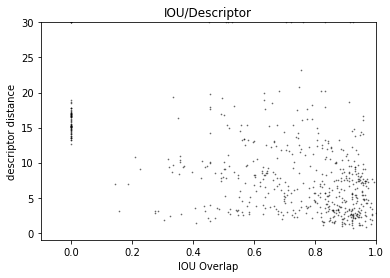

In [19]:
colors = (0,0,0)
area = np.pi*3
plt.scatter(iou_overlaps, desc_dists, s=0.5, c=colors, alpha=0.5)
plt.ylim((-1,30))
plt.xlim((-0.1,1))
plt.title('IOU/Descriptor')
plt.xlabel('IOU Overlap')
plt.ylabel('descriptor distance')
plt.savefig('graal_2.png')
plt.show()


33
descriptor distance = 13.75639453255852
iou overlap =  0.0


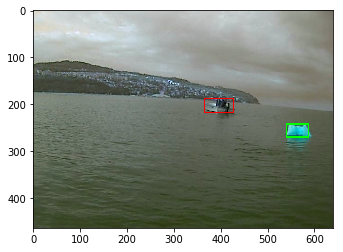

In [20]:
print(len(confusion_frames))
index = 26


display_confusion('modd',confusion_frames[index],confusion_tracks[index][0],confusion_tracks[index][1])


In [8]:
def display_confusion(datasetfolder,frame_id,track_box,det_box):
    frame = cv.imread('../%s/%s.jpg'%(datasetfolder,str(frame_id).zfill(5)))
    
    xmin = int(track_box[3])
    ymin = int(track_box[4])
    xmax =int(track_box[5])
    ymax =int(track_box[6])

    cv.rectangle(frame, (int(xmin), int(ymin)), (int(xmax),int(ymax)), (255,0,0), 2)
    xmin2 = int(det_box[3])
    ymin2 = int(det_box[4])
    xmax2 =int(det_box[5])
    ymax2 =int(det_box[6])

    cv.rectangle(frame, (int(xmin2), int(ymin2)), (int(xmax2),int(ymax2)), (0,255,0), 2)
    plt.figure()
    plt.imshow(frame)
    print('descriptor distance =',get_distance(track_box[10:],det_box[10:]))
    print('iou overlap = ',iou(corners(track_box),corners(det_box),coords='corners')[0][0])